# Erosion Model for Ocean Worlds 
This notebook contains code to reproduce the figures in Johnson et al. (2025), GRL: "Mechanical Erosion on Ocean World Seafloors". The model is adapted from Sklar and Dietrich (2004), as described in the paper and supplemental information. The main python functions for the model are contained in "erosion_funcs.py". 


In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib.pyplot import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from erosion_funcs import *
from scipy.optimize import fsolve
import matplotlib as mpl
import matplotlib
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

# First we'll make the threshold for motion figure

In [12]:
def spalding_for_meanflow(dimensionless_u):
    """Spalding 1961 equation for velocity profile near boundary at y+ = 2000"""
    return dimensionless_u + 0.1108*(np.exp(0.4*dimensionless_u)-1-0.4*dimensionless_u - (0.4*dimensionless_u)**2/2 - (0.4*dimensionless_u)**3 / 6)-2000


<IPython.core.display.Javascript object>


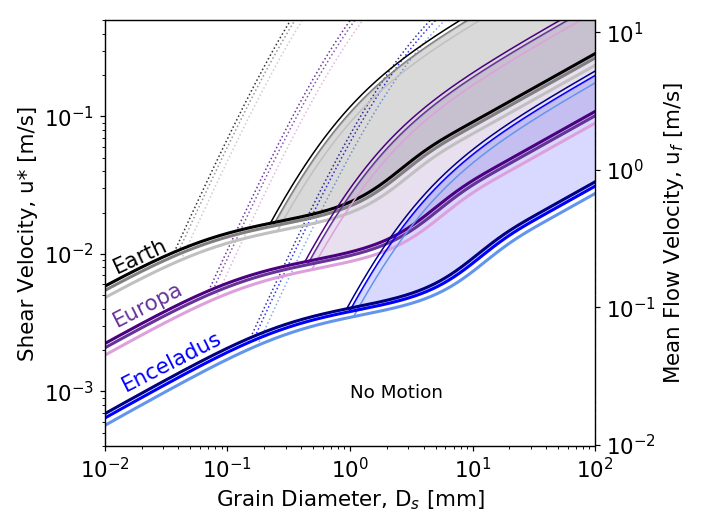

0
1
2


In [21]:
################ CREATING BURR+2006 STYLE FIG FOR TRANSPORT CATEGORIES (FIGURE 1)
names = ['Earth', 'Europa', 'Enceladus']
density_particle = [2300,2650,2900] #kg/m^3, density of gypsum, quartz, and basalt
grav_acc = [9.8,1.407,0.133] #m/s^2, density at the *seafloor* for Earth, Europa, Enceladus
viscosity = 1.7e-3*np.ones_like(grav_acc) #Pa*s, *dynamic* viscosity from Morrison+2022
density_liquid = 1050*np.ones_like(grav_acc) #kg/m^3, seawater at seafloor pressure
ls = ['-','--',':','-.']
gradient = [['silver','gray','k'],['plum','rebeccapurple','indigo'],['cornflowerblue','b','navy']]
colors = ['k','rebeccapurple','b']

#values from Burr+2006
K1 = 0.428
K2 = 0.824
k_ratio_bed_sus = 1.25
k_ratio_sus_wash = 0.075

#investigate range of friction reynolds numbers and calc corresponding shields threshold from Paphitis
reynolds_friction = np.logspace(-3,5,1000)
shields_threshold = 0.188/(1+reynolds_friction) + 0.0475*(1 - 0.699*np.exp(-0.015*reynolds_friction))

#set up figure
fig, ax = plt.subplots()

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Grain Diameter, D$_s$ [mm]',fontsize = 14)
plt.ylabel('Shear Velocity, u* [m/s]',fontsize = 14)
plt.ylim([4e-4,0.5])
plt.xlim([1e-2,1e2])
plt.tick_params(labelsize = 14)

#calculate the threshold for motion as a function of grain size
for i in [0,1,2]:
    print(i)
    for j in range(len(density_particle)):
        diameter_cubed = density_liquid[i] / (shields_threshold*(density_particle[j] - density_liquid[i])*grav_acc[i])*(reynolds_friction*viscosity[i]/density_liquid[i])**2 #use definition of Re* and shields criteria to solve for grain size
        diameter = (diameter_cubed)**(1/3)
        velocity_friction = reynolds_friction*viscosity[i] / (density_liquid[i]*diameter) #find corresponding frictional velocity
        plt.plot(diameter*1e3,velocity_friction,color = gradient[i][j],linewidth = 2)

        ############### CALCULATING TRANSPORT TYPE: BED/SUSPEND/WASH #####################
        dimensionless_diam = diameter * (grav_acc[i]*density_liquid[i]*(density_particle[j] - density_liquid[i])/viscosity[i]**2)**(1/3) #equations from Burr+2006
        dimensionless_velocity_settling = ((18/dimensionless_diam**2)**K2+(3*K1/(4*dimensionless_diam))**(K2/2))**(-1/K2)
        velocity_settling = dimensionless_velocity_settling * (density_liquid[i]**2 / (grav_acc[i]*viscosity[i]*(density_particle[j]-density_liquid[i])))**(-1/3)

        velocity_fric_bed_sus = velocity_settling / k_ratio_bed_sus #curve that define boundary between bed and suspended load
        velocity_fric_sus_wash = velocity_settling / k_ratio_sus_wash #curve that define boundary between suspended load and washload

        idx_bed_sus = np.argmin(np.abs(velocity_fric_bed_sus - velocity_friction)) #find where the boundary curve intersects the threshold for motion and only plot the section that exceeds the threshold velocity
        idx_sus_wash = np.argmin(np.abs(velocity_fric_sus_wash - velocity_friction))

        plt.plot(diameter[idx_bed_sus:]*1e3,velocity_fric_bed_sus[idx_bed_sus:],color = gradient[i][j],linewidth = 1)
        plt.plot(diameter[idx_sus_wash:]*1e3,velocity_fric_sus_wash[idx_sus_wash:],color = gradient[i][j],linewidth = 1,linestyle = ':',zorder = -10,alpha = 0.8)
    
        #shading the bedload region
        if j == 1:
            plt.fill_between(diameter[idx_bed_sus:]*1e3,velocity_friction[idx_bed_sus:],velocity_fric_bed_sus[idx_bed_sus:],color = colors[i],alpha = 0.15)
    
    #labeling each set of curve
    if i == 0:
        plt.annotate('Earth',xy = (1.1e-2,1.05e-2),color = colors[i],fontsize = 14,rotation = 25)        
    elif i == 1:
        plt.annotate('Europa',xy = (1.1e-2,5e-3),color = colors[i],fontsize = 14,rotation = 27)
    elif i == 2:
        plt.annotate('Enceladus',xy = (1.3e-2,2.2e-3),color = colors[i],fontsize = 14,rotation = 27)
        
    
    ##################### TRANSLATING INTO MEAN FLOW VELOCITY ######################
    if i == 2: 
        shear_vel = np.arange(4.1e-5,1e1,1e-6) #arbitrary range of shear velocities
        dimensionless_u = fsolve(spalding_for_meanflow,24)[0]
        mean_flow_velocity = shear_vel*dimensionless_u #corresponding mean flow velocities  
        
        #making second y axis to show the mean flow velocity
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        plt.yscale('log')   
        
        b = ['10$^{-2}$','10$^{-1}$','10$^{0}$','10$^{1}$'] #these are the ticks I WANT for mean flow
        mean_flow_values = [1e-2,1e-1,1,10]
        mean_flow_axis_shears = []
        for j in range(len(mean_flow_values)):
            idx = np.argmin(abs(mean_flow_velocity - mean_flow_values[j]))
            mean_flow_axis_shears.append(shear_vel[idx]) #these are the equivalent shear velocities for the ticks above
        
        new_tick_locations = np.asarray(mean_flow_axis_shears)
        ax2.set_yticks(new_tick_locations)
        ax2.set_yticklabels(b)
        plt.ylabel(r'Mean Flow Velocity, u$_f$ [m/s]',color = 'k',fontsize = 14)
        plt.tick_params(labelsize = 14,colors = 'k')
        plt.tick_params(axis = 'y',which = 'minor',colors = 'w')

plt.annotate('No Motion',xy = (1,9e-4),fontsize = 12)
plt.tight_layout()



# Now we'll make the 9-panel erosion rate figs

In [17]:
planet_names = ['Europa','Enceladus']

#model constants
density_fluid = 1050 #kg/m^3
youngs_modulus = 7.5e10 #1.1e-6Pa
rock_resistance = 1.47e6 #unitless, SD04 correction
tensile_strength = 14e6 #Pa, SD04
kinematic_viscosity = 1.6e-6 #m^2/s, from Morrison+2022 and our assumed fluid density
stress_nondim_threshold = 0.03 #SD04

<IPython.core.display.Javascript object>


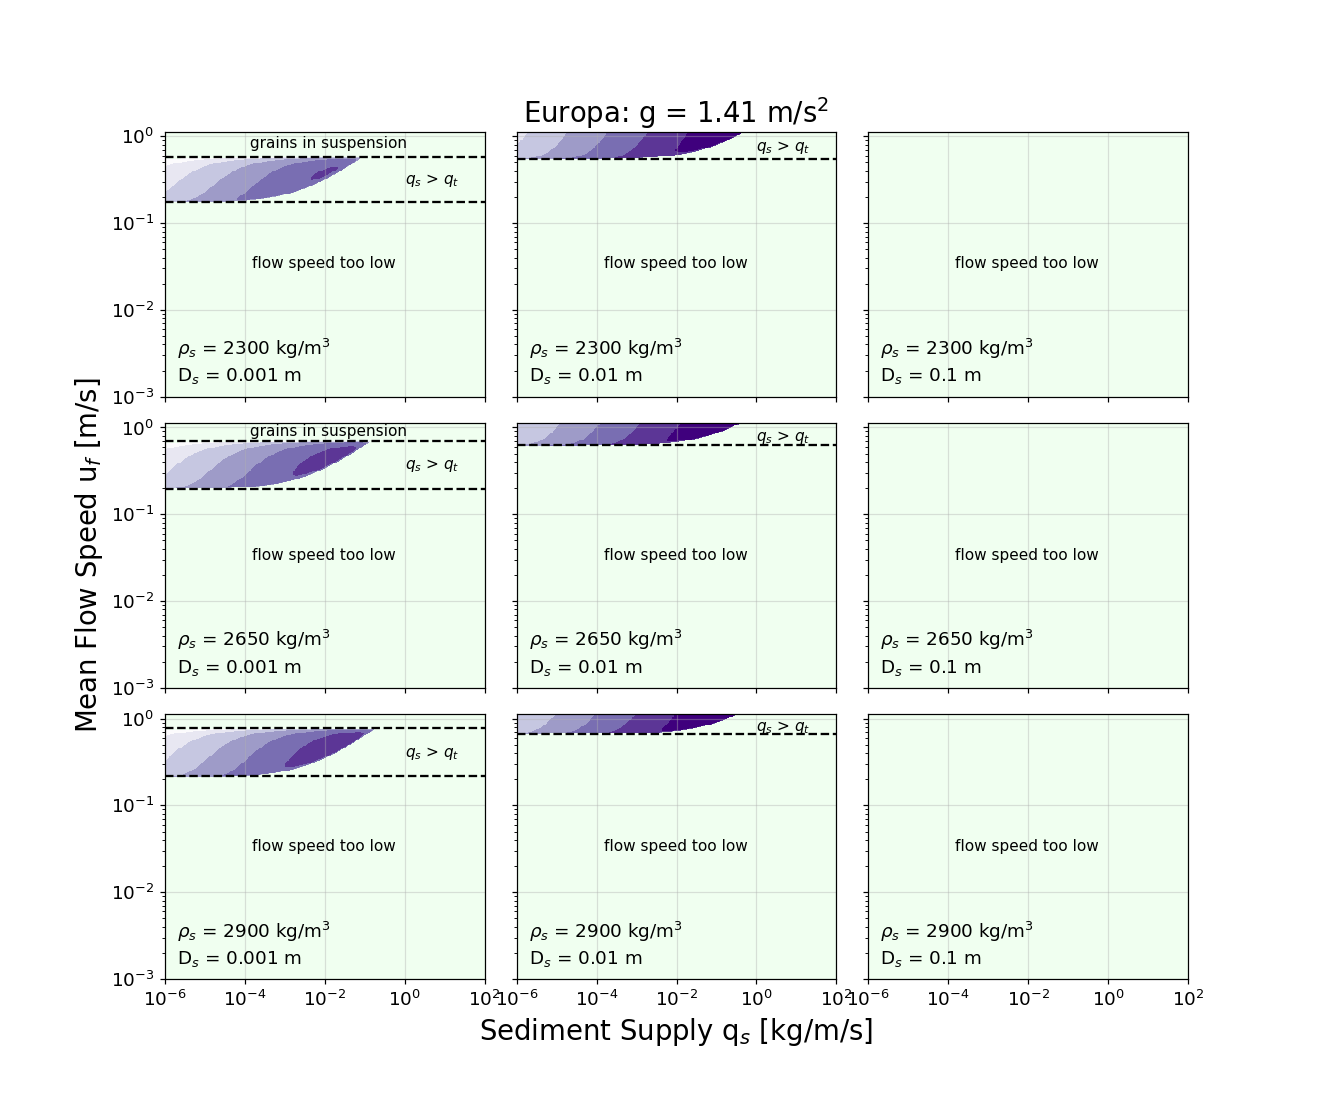

2300 0.001


/home/peri/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


2300 0.01
2300 0.1
2650 0.001
2650 0.01
2650 0.1
2900 0.001
2900 0.01
2900 0.1


In [22]:
######################## 9-PANEL FIG FOR EUROPA GRAVITY AND VELOCITIES (takes a few min to run) (FIGURE 2A)
#model variables
grav_acc = 1.41# m/s^2
density_grain = [2300,2650,2900] #kg/m^3
diameter = [0.001,0.01,0.1] #m
mean_flow_speed = np.logspace(-3,0.05,300) #m/s
sediment_supply_per_width = np.logspace(-6,2,300) #kg/width/time

fig,axes = plt.subplots(3,3,figsize = (12,10),sharex=True,sharey=True)

#colorbar setup
cmap = mpl.cm.Purples
cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the .jet map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N) # create the new map
cmap.set_under('honeydew') #any cell less than vmin will be a cute green
bounds = np.arange(-5, 2.01, 1) # define the bins and normalize
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

#calculating erosion rate as func of density and size
for i_density in range(len(density_grain)):
    for i_size in range(len(diameter)):
        print(density_grain[i_density],diameter[i_size])
        incision_rate = np.zeros((len(mean_flow_speed),len(sediment_supply_per_width))) #initializing array
        u_star = np.zeros_like(mean_flow_speed)
        for i in range(len(mean_flow_speed)):
            incision_rate[i,:], why_zero, u_star[i] = erosion_rate_final(sediment_supply_per_width, mean_flow_speed[i], diameter[i_size], tensile_strength, density_fluid, density_grain[i_density], grav_acc, rock_resistance, youngs_modulus, kinematic_viscosity, stress_nondim_threshold)

        log_incision_rate = np.where(np.isnan(incision_rate),-99999999,np.log10(incision_rate*1000*365.25*24*3600*1000)) #getting array reading to be plottable by adjusting nans and infs (where erosion rate is zero)
        log_incision_rate = np.where(np.isinf(log_incision_rate),-99999999,log_incision_rate)
        incision_rate = np.where(np.isnan(incision_rate),0,incision_rate)
        
        c = axes[i_density,i_size].pcolormesh(sediment_supply_per_width,mean_flow_speed,log_incision_rate,cmap = cmap,vmin = -5,vmax=1.5,norm=norm) #plotting the erosion rate!
        
        #plot set up
        axes[i_density,i_size].set_yscale('log')
        axes[i_density,i_size].set_xscale('log')
        axes[i_density,i_size].grid(alpha = 0.4)
        axes[i_density,i_size].annotate(r'$\rho_s$ = '+str(density_grain[i_density])+r' kg/m$^3$',xy = (2e-6,0.3e-2),fontsize = 12)
        axes[i_density,i_size].annotate(r'D$_s$ = '+str(diameter[i_size])+' m',xy = (2e-6,0.15e-2),fontsize = 12)

        #dotted lines to show different ways that E can =0
        array_to_check = log_incision_rate[:,0] #looking at column of erosion rate when sed supply is at lowest value
        
        if i_size != 2:
            idx_min = np.where(array_to_check > -999)[0][0] #find index of min flow speed that has erosion
            idx_max = np.where(array_to_check > -999)[0][-1] #find index of max flow speed that has erosion
            axes[i_density,i_size].axhline(y=mean_flow_speed[idx_min],linestyle = '--',color = 'k')
            axes[i_density,i_size].annotate('flow speed too low',xy = (1.5e-4,3e-2),fontsize = 10)
            
            #putting annotations in good spots so they don't overlap anything
            if i_size == 0:
                axes[i_density,i_size].annotate(r'$q_s$ > $q_t$',xy = (1,0.75*(mean_flow_speed[idx_min]+mean_flow_speed[idx_max])/2),fontsize = 10)
            if i_size == 1:
                axes[i_density,i_size].annotate(r'$q_s$ > $q_t$',xy = (1,0.8*(mean_flow_speed[idx_min]+mean_flow_speed[idx_max])/2),fontsize = 10)
            
            #check if erosion rate is zero at the highest velocity we calculated it at
            if idx_max < len(mean_flow_speed)-1:
                axes[i_density,i_size].axhline(y=mean_flow_speed[idx_max+1],linestyle = '--',color = 'k')
                if i_density == 0:
                    axes[i_density,i_size].annotate(' grains in suspension',xy = (1e-4,1.3*mean_flow_speed[idx_max]),fontsize = 10)
                elif i_density == 1:
                    axes[i_density,i_size].annotate(' grains in suspension',xy = (1e-4,0.8),fontsize = 10)

        elif i_size == 2:
            axes[i_density,i_size].annotate('flow speed too low',xy = (1.5e-4,3e-2),fontsize = 10)
        
axes[2,1].set_xlabel('Sediment Supply q$_s$ [kg/m/s]',fontsize = 18)
axes[1,0].set_ylabel('Mean Flow Speed u$_f$ [m/s]',fontsize = 18)
axes[0,1].set_title('Europa: g = '+str(grav_acc)+' m/s$^2$',fontsize = 18)       
plt.subplots_adjust(wspace=0.1, hspace=0.1)        
#plt.tight_layout()
        
        


<IPython.core.display.Javascript object>


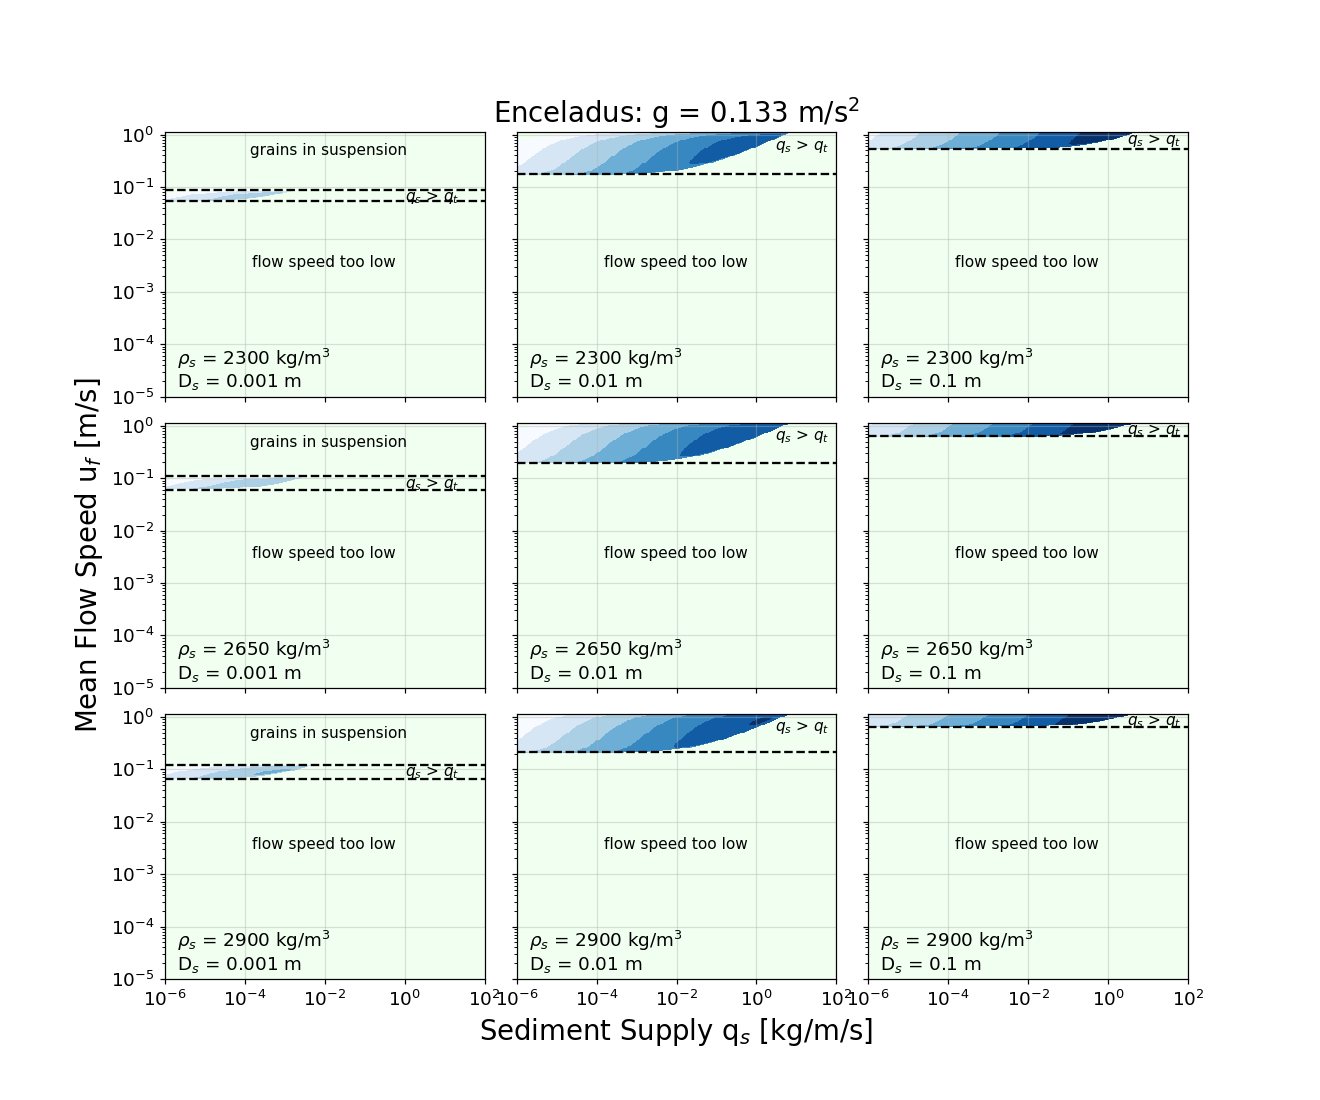

2300 0.001
couldn't find a good match! Extending trial tau values
New diff: 0.0213698237130302, Final $\tau$ = 1.749042017799838e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.004043165684379346, Final $\tau$ = 1.8905156487183364e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.013283326367627524, Final $\tau$ = 2.043432565756659e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03060965236500124, Final $\tau$ = 2.2087183746009505e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.047935812385503596, Final $\tau$ = 2.387373549806101e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.06526180639843915, Final $\tau$ = 2.580479490665508e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0825876343640175, Final $\tau$ = 2.789205066918042e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.09991329631657209, Final $\tau$ = 3.0

New diff: 0.020880367804011257, Final $\tau$ = 2.7444317719184947e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0035537144672161958, Final $\tau$ = 2.9664188503477513e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.013772772870652261, Final $\tau$ = 3.206361654072786e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03109909420140866, Final $\tau$ = 3.4657125562370155e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.04842524951254745, Final $\tau$ = 3.746041407151329e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0657512388579562, Final $\tau$ = 4.04904503659382e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.08307706213531674, Final $\tau$ = 4.376557524715765e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.10040271941761603, Final $\tau$ = 4.730561303723943e-08 Pa
couldn't find a good match! Extending tria

/home/peri/Documents/Research/py/erosion/erosion_funcs.py:209: RuntimeWarning: overflow encountered in exp
  right_side = dimensionless_u + 0.1108*(np.exp(0.4*dimensionless_u)-1-0.4*dimensionless_u - (0.4*dimensionless_u)**2/2 - (0.4*dimensionless_u)**3 / 6)


couldn't find a good match! Extending trial tau values
New diff: 0.020586694325174903, Final $\tau$ = 5.699591837602798e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.003260043797581602, Final $\tau$ = 6.160611037720941e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.014066440728129237, Final $\tau$ = 6.658920399824972e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03139275924309004, Final $\tau$ = 7.197536189138922e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.048718911745254445, Final $\tau$ = 7.779718645581947e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.06604489824985649, Final $\tau$ = 8.408991717991828e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.08337071873233981, Final $\tau$ = 9.089164394577594e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.100696373199753, Final $\tau$ = 9.8243537587151

/home/peri/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


221 232
2300 0.01
couldn't find a good match! Extending trial tau values
New diff: 0.0213698237130302, Final $\tau$ = 1.749042017799838e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.004043165684379346, Final $\tau$ = 1.8905156487183364e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.013283326367627524, Final $\tau$ = 2.043432565756659e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03060965236500124, Final $\tau$ = 2.2087183746009505e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.047935812385503596, Final $\tau$ = 2.387373549806101e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.06526180639843915, Final $\tau$ = 2.580479490665508e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0825876343640175, Final $\tau$ = 2.789205066918042e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.09991329631657209, Final $\tau

couldn't find a good match! Extending trial tau values
New diff: 0.020880367804011257, Final $\tau$ = 2.7444317719184947e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0035537144672161958, Final $\tau$ = 2.9664188503477513e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.013772772870652261, Final $\tau$ = 3.206361654072786e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03109909420140866, Final $\tau$ = 3.4657125562370155e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.04842524951254745, Final $\tau$ = 3.746041407151329e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0657512388579562, Final $\tau$ = 4.04904503659382e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.08307706213531674, Final $\tau$ = 4.376557524715765e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.10040271941761603, Final $\tau$ = 4.7305613037

New diff: 0.06535969290439425, Final $\tau$ = 7.093014551748513e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.08268551992637185, Final $\tau$ = 7.666742634082351e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.10001118094282901, Final $\tau$ = 8.286877488890288e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.1078098125105953, Final $\tau$ = 8.956966546417769e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.09048232625218589, Final $\tau$ = 9.681462908678554e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0731550059390429, Final $\tau$ = 1.0464561139798548e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.055827851731692135, Final $\tau$ = 1.1311001331257312e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.038500863502576976, Final $\tau$ = 1.2225906983249578e-09 Pa
couldn't find a good match! Extending trial 

New diff: 0.06584912533321585, Final $\tau$ = 1.1129689450792016e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.08317494766970412, Final $\tau$ = 1.20299294459292e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.10050060401636074, Final $\tau$ = 1.3002986571537819e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.10732033320618939, Final $\tau$ = 1.4054427120579994e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.08999285161849002, Final $\tau$ = 1.5191238480737649e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.07266553603380999, Final $\tau$ = 1.6420002366423085e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.055338386514904414, Final $\tau$ = 1.7748156482120298e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.038011402974916564, Final $\tau$ = 1.918374014110742e-07 Pa
couldn't find a good match! Extending tr

New diff: 0.07305711194248943, Final $\tau$ = 2.876414430370471e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.055729958671463464, Final $\tau$ = 3.109077104765664e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03840297142073723, Final $\tau$ = 3.360559014485633e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.021076150154840434, Final $\tau$ = 3.6323823788512613e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.003749494938801945, Final $\tau$ = 3.9261925439534645e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.013576994296727207, Final $\tau$ = 4.24376794192874e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03090331748239805, Final $\tau$ = 4.587030855803969e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.048229474655045124, Final $\tau$ = 4.958059055070501e-09 Pa
couldn't find a good match! Extending tri

New diff: 0.07256764206476873, Final $\tau$ = 4.5133982326186575e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.05524049348127846, Final $\tau$ = 4.878470557497916e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03791351088875672, Final $\tau$ = 5.273072251496341e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.020586694325174903, Final $\tau$ = 5.699591837602798e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.003260043797581602, Final $\tau$ = 6.160611037720941e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.014066440728129237, Final $\tau$ = 6.658920399824972e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03139275924309004, Final $\tau$ = 7.197536189138922e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.048718911745254445, Final $\tau$ = 7.779718645581947e-07 Pa
couldn't find a good match! Extending tria

New diff: 0.01367488357914226, Final $\tau$ = 1.1664928117131143e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.031001205842358104, Final $\tau$ = 1.2608461616234726e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.048327362072086544, Final $\tau$ = 1.3628314099475287e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.06565335237883119, Final $\tau$ = 1.473065873118172e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.08297917658819642, Final $\tau$ = 1.5922168000434765e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.10030483481455121, Final $\tau$ = 1.7210054109625817e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.10751612491208107, Final $\tau$ = 1.8601684304928743e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.09018864144809413, Final $\tau$ = 2.0106306717104065e-08 Pa
couldn't find a good match! Extending 

New diff: 0.09991329631657209, Final $\tau$ = 3.01481369391349e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.10790770838912067, Final $\tau$ = 3.2585959471788225e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.09058022119052112, Final $\tau$ = 3.5221718908394565e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0732528999412807, Final $\tau$ = 3.8070675314501805e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.05592574479419454, Final $\tau$ = 4.1150073415547423e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03859875562875459, Final $\tau$ = 4.4478552799927097e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.021271932521585768, Final $\tau$ = 4.807626074437167e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.003945275430169204, Final $\tau$ = 5.196497416535998e-10 Pa
couldn't find a good match! Extending tria

couldn't find a good match! Extending trial tau values
New diff: 0.10741822905356457, Final $\tau$ = 5.113081423013501e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.09009074652908566, Final $\tau$ = 5.526659934412331e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.07276343001535679, Final $\tau$ = 5.973691303479534e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.055436279556033696, Final $\tau$ = 6.45688140988567e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0381092950801758, Final $\tau$ = 6.979155002040872e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.020782476641215908, Final $\tau$ = 7.543673400588999e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.003455824240745642, Final $\tau$ = 8.153853633872998e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.013870662161707514, Final $\tau$ = 8.8133891211982

couldn't find a good match! Extending trial tau values
New diff: 0.021174041332415072, Final $\tau$ = 1.3214816017217729e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0038473851800517878, Final $\tau$ = 1.4283714296875684e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.013479104995440139, Final $\tau$ = 1.543907186062567e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0308054291137978, Final $\tau$ = 1.6687882084683017e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.04813158726142319, Final $\tau$ = 1.8037704013963878e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.06545757939829855, Final $\tau$ = 1.9496708116963543e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.082783405480086, Final $\tau$ = 2.1073725741579954e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.10010906556522059, Final $\tau$ = 2.27783025

couldn't find a good match! Extending trial tau values
New diff: 0.020684585479330053, Final $\tau$ = 2.0735442927398103e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.003357934014957209, Final $\tau$ = 2.2412657293770188e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.013968551451171152, Final $\tau$ = 2.4225535414257167e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.031294870898364024, Final $\tau$ = 2.6185050635229944e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.04862102433662585, Final $\tau$ = 2.8303063897032934e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0659470117852834, Final $\tau$ = 3.059239552822418e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.08327283320340939, Final $\tau$ = 3.30669028469889e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.10059848861010323, Final $\tau$ = 3.57415640

New diff: 0.06555546589129335, Final $\tau$ = 5.359098372417235e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.08288129104016662, Final $\tau$ = 5.792576297749757e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.1002069501778351, Final $\tau$ = 6.2611166717803105e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.10761402077309867, Final $\tau$ = 6.767399741041022e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.09028653638983997, Final $\tau$ = 7.314790028694789e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.07295921795412141, Final $\tau$ = 7.906456720652081e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.05563206562214873, Final $\tau$ = 8.545981173802538e-09 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.038305079269548514, Final $\tau$ = 9.237234427935284e-09 Pa
couldn't find a good match! Extending trial ta

New diff: 0.06604489824985649, Final $\tau$ = 8.408991717991828e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.08337071873233981, Final $\tau$ = 9.089164394577594e-07 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.100696373199753, Final $\tau$ = 9.824353758715111e-07 Pa
256 299
2900 0.1
couldn't find a good match! Extending trial tau values
New diff: 0.0213698237130302, Final $\tau$ = 1.749042017799838e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.004043165684379346, Final $\tau$ = 1.8905156487183364e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.013283326367627524, Final $\tau$ = 2.043432565756659e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03060965236500124, Final $\tau$ = 2.2087183746009505e-10 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.047935812385503596, Final $\tau$ = 2.387373549806101e-10 Pa
couldn't find a good match! 

New diff: 0.07286132398780865, Final $\tau$ = 2.1732632549577755e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.05553417259602611, Final $\tau$ = 2.3490505948224813e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.038207187179523316, Final $\tau$ = 2.539056731598342e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.020880367804011257, Final $\tau$ = 2.7444317719184947e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.0035537144672161958, Final $\tau$ = 2.9664188503477513e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.013772772870652261, Final $\tau$ = 3.206361654072786e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.03109909420140866, Final $\tau$ = 3.4657125562370155e-08 Pa
couldn't find a good match! Extending trial tau values
New diff: 0.04842524951254745, Final $\tau$ = 3.746041407151329e-08 Pa
couldn't find a good match! Extending

In [23]:
######################## 9-PANEL FIG FOR ENCELADUS GRAVITY AND VELOCITIES (takes a few min to run...please ignore the errors about tau) (FIGURE 2B)
#model variables
grav_acc = 0.133 #m/s, Enceladus *seafloor* velocity
density_grain = [2300,2650,2900] #density of gypsum, quartz, and basalt in kg/m^3
diameter = [0.001,0.01,0.1] #m, following SD04
mean_flow_speed = np.logspace(-5,0.05,300)#np.asarray([2.37])
sediment_supply_per_width = np.logspace(-6,2,300) #kg/width/time

fig,axes = plt.subplots(3,3,figsize = (12,10),sharex=True,sharey=True)

#colorbar setup
cmap = mpl.cm.Blues
cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the .jet map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N) # create the new map
cmap.set_under('honeydew')
bounds = np.arange(-5, 2.01, 1) # define the bins and normalize
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for i_density in range(len(density_grain)):
    for i_size in range(len(diameter)):
        print(density_grain[i_density],diameter[i_size])
        incision_rate = np.zeros((len(mean_flow_speed),len(sediment_supply_per_width)))
        u_star = np.zeros_like(mean_flow_speed)
        for i in range(len(mean_flow_speed)):
            incision_rate[i,:], why_zero, u_star[i] = erosion_rate_final(sediment_supply_per_width, mean_flow_speed[i], diameter[i_size], tensile_strength, density_fluid, density_grain[i_density], grav_acc, rock_resistance, youngs_modulus, kinematic_viscosity, stress_nondim_threshold)

        log_incision_rate = np.where(np.isnan(incision_rate),-99999999,np.log10(incision_rate*1000*365.25*24*3600*1000))
        log_incision_rate = np.where(np.isinf(log_incision_rate),-99999999,log_incision_rate)
        incision_rate = np.where(np.isnan(incision_rate),0,incision_rate)
        
        c = axes[i_density,i_size].pcolormesh(sediment_supply_per_width,mean_flow_speed,log_incision_rate,cmap = cmap,vmin = -5,vmax=1.5,norm=norm)
        
        axes[i_density,i_size].set_yscale('log')
        axes[i_density,i_size].set_xscale('log')
        axes[i_density,i_size].grid(alpha = 0.4)
        axes[i_density,i_size].annotate(r'$\rho_s$ = '+str(density_grain[i_density])+r' kg/m$^3$',xy = (2e-6,0.4e-4),fontsize = 12)
        axes[i_density,i_size].annotate(r'D$_s$ = '+str(diameter[i_size])+' m',xy = (2e-6,0.15e-4),fontsize = 12)
        
        #dotted lines to show different ways that E can =0
        array_to_check = log_incision_rate[:,0]
        
        if i_size != 10:
            idx_min = np.where(array_to_check > -999)[0][0] #find index of min flow speed that has erosion
            idx_max = np.where(array_to_check > -999)[0][-1] #find index of max flow speed that has erosion
            print(idx_min,idx_max)
            axes[i_density,i_size].axhline(y=mean_flow_speed[idx_min],linestyle = '--',color = 'k')
            axes[i_density,i_size].annotate('flow speed too low',xy = (1.5e-4,3e-3),fontsize = 10)
            
            if i_size == 0:
                axes[i_density,i_size].annotate(r'$q_s$ > $q_t$',xy = (1,0.8*(mean_flow_speed[idx_min]+mean_flow_speed[idx_max])/2),fontsize = 10)
            if i_size >= 1:
                axes[i_density,i_size].annotate(r'$q_s$ > $q_t$',xy = (3,0.8*(mean_flow_speed[idx_min]+mean_flow_speed[idx_max])/2),fontsize = 10)

            if idx_max < len(mean_flow_speed)-1 and i_size == 0:
                axes[i_density,i_size].axhline(y=mean_flow_speed[idx_max+1],linestyle = '--',color = 'k')
                axes[i_density,i_size].annotate(' grains in suspension',xy = (1e-4,0.4),fontsize = 10)
        
axes[2,1].set_xlabel('Sediment Supply q$_s$ [kg/m/s]',fontsize = 18)
axes[1,0].set_ylabel('Mean Flow Speed u$_f$ [m/s]',fontsize = 18)
axes[0,1].set_title('Enceladus: g = '+str(grav_acc)+' m/s$^2$',fontsize = 18)       
plt.subplots_adjust(wspace=0.1, hspace=0.1)        